# Description

This code loads in the bias-adjusted natural climate model simulations from the CMIP5 ensemble and pools them together to form a combined *counterfactual* (CF) distribution. 

Pooling follows the method of [Strauss et al. (2021)](https://www.nature.com/articles/s41467-021-22838-1), assuming that the range of the newly-formed pooled distribution of maximum temperatures represents an inter-model spread of pre-industrial temperatures across the globe. Using this pooled distribution along with the forced climate model runs lends a range to the resultant attribution analysis performed in XXXXXX.ipynb.

To limit the computational expense of storing/sampling this pooled distribution, results are aggregated at the distribution/histogram counts level with a pre-defined precision of 0.1$^{\circ}$C, and then are resampled in later codes when the CF distribution is called (see XXXXX.ipynb). Because many observations are reported to the nearest ~0.5$^{\circ}$C---including our own example attribution analyses in Phoenix---we consider 0.1$^{\circ}$C precision sufficient for the study.

# Setup

In [13]:
# import the packages we need to run this code
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import utilities as util
from xhistogram.xarray import histogram as xhist

In [18]:
# define the path to saved the pooled distribution into
pooled_savepath='./data/cmip5/cf/'

# choose the environmental state variable, the metric, we are looking at
metric='TMAX'

# Prepare to load bias-adjusted CMIP5 TMAX

In [17]:
# define the location of the bias-adjusted models
fLpath='/home/dgilford/fingerprints/data/bias_correction/'

# load the model names/directories that contain 'Nat' string
fl=[f for f in os.listdir(fLpath)]
fnat=[i for i in fl if 'Nat' in i]
modelnames=[s[:-49] for s in fnat]
nmodel=len(modelnames)

# print to see the 11 models
print(modelnames)
print('\n'+str(nmodel)+' Natural model runs located')

['CESM1-CAM5', 'CCSM4', 'NorESM1-M', 'GFDL-CM3', 'MIROC-ESM-CHEM', 'bcc-csm1-1', 'MRI-CGCM3', 'CSIRO-Mk3-6-0', 'CanESM2', 'MIROC-ESM', 'IPSL-CM5A-MR']

11 Natural model runs located


In [4]:
# define the month names and month integer array
monzarr='mon{:02d}.zarr'
months=np.arange(1,13)

### Load Land-sea Mask

We load in a land-sea mask to ignore the aggregated data over the oceans, as our analysis focuses on overland maximum temperature attribution.

In [5]:
lsmloadpath='./data/berkeley/berkeley_lsm.nc'
lsm=xr.open_dataset(lsmloadpath)

# Calculate Natural Distributions

We will create a set of bins that will allow us to directly aggregate the natural distributions into a single pooled model counterfactual distribution. We choose an appropriately fine precision for the aggregation, and build a set of bins that encompass the vast range of temperatures expected to be seen on Earth (-90$^{\circ}$C to 65$^{\circ}$C).

#### Construct Natural Distribution bins

In [6]:
# define the bins that we need to aggregate across observations
# define the minumum and maximum value of the bins in degrees C
minnat,maxnat=-90,65
# define the bin precision in degrees C
precision=1e-1
# store the bin edges associated with these parameters
binedges=np.arange(minnat-precision/2,maxnat+3/2*precision,precision)
# find the middle/central points of each invidual bin
midbins=binedges[:-1]+precision/2

# Test Xhistogram

Let's test [Xhistogram](https://xhistogram.readthedocs.io/en/latest/tutorial.html) for use in our project... and see if we can replace the loop in the original code.

In [30]:
# define the location to look at the distributions
# here we take Phoenix, which is located at
# (33.44837 N, 112.07404 W)
eg_loc=[util.lon180to360(-112.07404),33.44837]

In [19]:
f0=fLpath+fnat[0]+'/'
dat0=util.load_zarr_local(f0,monzarr.format(7))[metric].load()

In [52]:
h = xhist(dat0.load(),bins=binedges,dim=['time'])
h

<xarray.DataArray 'histogram_TMAX' (lat: 145, lon: 192, TMAX_bin: 1551)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * lat       (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon       (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * TMAX_bin  (TMAX_bin) float64 -90.0 -89.9 -89.8 -89.7 ... 64.7 64.8 64.9 65.0

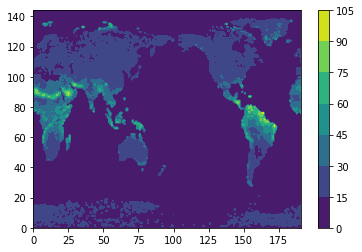

In [41]:
plt.contourf(h.max(dim='TMAX_bin'))
plt.colorbar()
plt.show()

Note that NaNs are binned as zeroes! We will need to account for this by apply the LSM *after* making the counts with Xhistogram.

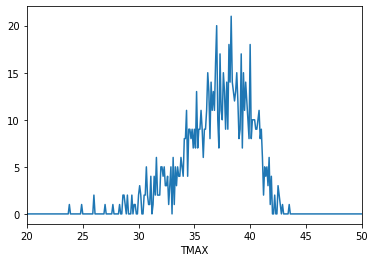

In [40]:
plt.plot(h['TMAX_bin'],h.sel(lon=eg_loc[0],lat=eg_loc[1],method='nearest'))
plt.xlim([20,50])
plt.xlabel('TMAX')
plt.show()

# Compare with loop method

In [48]:
# calculate at the individual location with numpy hist
histgrab=np.histogram(dat0.sel(lon=eg_loc[0],lat=eg_loc[1],method='nearest').values,bins=binedges)
histgrab

(array([0, 0, 0, ..., 0, 0, 0]),
 array([-90.05, -89.95, -89.85, ...,  64.85,  64.95,  65.05]))

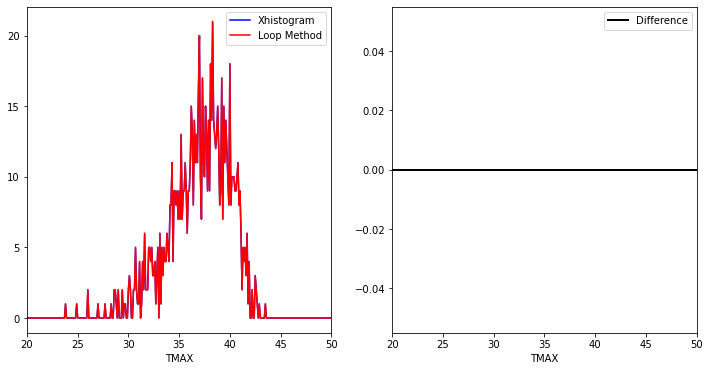

In [54]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(h['TMAX_bin'],h.sel(lon=eg_loc[0],lat=eg_loc[1],method='nearest'),
         color='blue',label='Xhistogram')
plt.plot(h['TMAX_bin'],histgrab[0],
         color='red',label='Loop Method')
plt.xlim([20,50])
plt.xlabel('TMAX')
plt.legend()

plt.subplot(1,2,2)
plt.plot(h['TMAX_bin'],histgrab[0]-h.sel(lon=eg_loc[0],lat=eg_loc[1],method='nearest'),
         color='k',lw=2,label='Difference')
plt.xlim([20,50])
plt.xlabel('TMAX')
plt.legend()
plt.show()

## Load+bin natural model runs to form a pooled Counterfactual

In [5]:
# loop over the natural model runs
for fi in fnat:
    
    # define the model name
    mname=fi[:-49]
    
    # load in the point for this model
    for mi in months:
        
        # load the bias-adjusted model data by month
        filepath_in=cmip5_raw_filepath+forced_zarrpath
        datin=util.load_zarr_local(filepath_in,monzarr.format(mi)).load()
        
        # get the timegrid into memory in the first iteration of the loops
        if mi==1 and fi==fnat[0]:
            timegrid=datin.time
            
        # define the data array for the binned histogram across this model in this month
        nathist=np.zeros((len(lsm.lon),len(lsm.lat),len(midbins)),dtype='int32')
        
        # loop over all geolocations
        for xi in range(len(lsm.lon)):
            for yi in range(len(lsm.lat)):
                # apply the land-sea mask, if over ocean
                if lsm.lsm.isel(lat=yi,lon=xi).values==False:
                    continue
                # if the data itself at this location is NaN, 
                # skip this location (~apply lsm)
                if np.isnan(datin.TMAX.isel(lat=yi,lon=xi).values).all()==True:
                    continue
                # for valid locations, calculate the!!!!!!!!!!!!!!!!!!!!!!!
                else:
                    histgrab=np.histogram(datin.TMAX.isel(lat=yi,lon=xi).values,bins=binedges)
                    nathist[xi,yi,:]=histgrab[0]
        del datin
    
        # create the xarray we need for storing the histogram
        savename=mname+'_'+str(mi).zfill(2)+'_NaturalHist.zarr'
        varname=mname+'_Nat_'+str(mi).zfill(2)
        
        Natdist = xr.Dataset(
                    data_vars=dict(
                        placeholder=(["lon","lat","bins"], nathist),
                        ),
                    coords=dict(
                            lon=lsm.lon,
                            lat=lsm.lat,
                            time=timegrid,
                            bins=midbins,
                        ),
                    ).rename({'placeholder':varname})
        del nathist

        # save out the result
        util.save_zarr_local(Natdist,savepath,savename)
        del Natdist, savename
 
        # tell the user where we are
        print('Completed count/save for month=='+str(mi))
    
    # tell the user where we are
    print('Completed Natural histogram creation for all months of model=='+mname)
    
# tell the user we are finished
print('Done')


By binning the way I have, we have somewhat reduced the precision of the data. This begs the question, what data precision is required for the extreme value analysis.

# Pool Natural Distributions

### Pool Natural distributions across models

In [42]:
# time the load/save
savepath='/home/dgilford/fingerprints/data/analysis/paper/natural_distributions/cmip5_pooled/'
loadpath='/home/dgilford/fingerprints/data/analysis/paper/natural_distributions/cmip5_point1/'
t0=time.time()

# loop over the months
for mi in np.arange(1,13):
    
    # define the monthly variable name we will use to sum counts
    mon_varname='NaturalHist_'+str(mi).zfill(2)

    # loop over the models
    for fi in fnat:
    
        # define the model name, and variable name in the dataset we will replace
        mname=fi[:-49]
        varname=mname+'_Nat_'+str(mi).zfill(2)
        
        # define the name of this month we are loading
        zname=mname+'_'+str(mi).zfill(2)+'_NaturalHist.zarr'

        # load the data pointer for the natural distributions
        natdistin=util.load_zarr_local(loadpath,zname).drop('time').rename({varname:mon_varname}).load()
        
        # if this is the first iteration, create what we need
        if fi==fnat[0]:
            monthpool=natdistin.copy(deep=True)
        else:
            monthpool=monthpool+natdistin
        del natdistin
        #plt.plot(monthpool.bins,monthpool.sum({'lat','lon'}).to_array().squeeze())
    
    # save out the result
    savename='CMIP5_pooledNatdist_map_'+str(mi).zfill(2)+'.zarr'
    util.save_zarr_local(monthpool,savepath,savename)
    del monthpool, savename
    
    # tell the user where we are
    print('Completed pooling/save for month=='+str(mi))
    

Completed pooling/save for month==1
Completed pooling/save for month==2
Completed pooling/save for month==3
Completed pooling/save for month==4
Completed pooling/save for month==5
Completed pooling/save for month==6
Completed pooling/save for month==7
Completed pooling/save for month==8
Completed pooling/save for month==9
Completed pooling/save for month==10
Completed pooling/save for month==11
Completed pooling/save for month==12


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

## Plots: Annual

#### Load in Data/Pool across all months

In [73]:
loadpath='/home/dgilford/fingerprints/data/analysis/paper/natural_distributions/cmip5_pooled/'

# loop over the months
for mi in np.arange(1,13):
    
    # define the path/name to load from
    zarrname='CMIP5_pooledNatdist_map_'+str(mi).zfill(2)+'.zarr'
    # define the variable names
    mon_varname='NaturalHist_'+str(mi).zfill(2)
    
    # load the data pointer for the natural distributions
    datin=util.load_zarr_local(loadpath,zarrname).load()
    
    if mi==1:
        pooledNat=datin.copy(deep=True)
    else:
        pooledNat[mon_varname]=datin[mon_varname]
    
# after we have all of the data loaded in, sum across locations for an annual count
vars_to_sum = ['NaturalHist_'+str(ki).zfill(2) for ki in np.arange(1,13)]
summed_variables = pooledNat[vars_to_sum].to_array().sum("variable")
pooledNat['NaturalHist_Annual']=summed_variables

#### Histogram

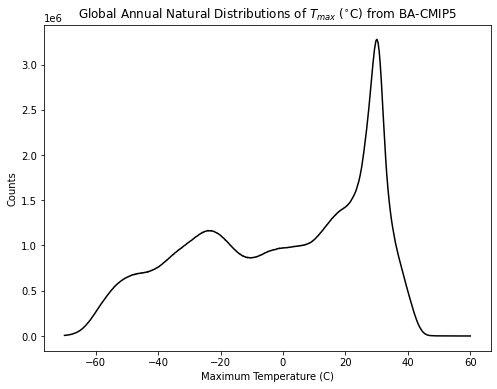

In [87]:
# set up the plot
cmap=plt.get_cmap('viridis')
plt.figure(figsize=(8,6))

plt.plot(pooledNat.bins,pooledNat['NaturalHist_Annual'].sum({'lat','lon'}).squeeze(),color='k')
    
# set other aspects of the plot
plt.xlabel('Maximum Temperature (C)')
plt.ylabel('Counts')
plt.title('Global Annual Natural Distributions of $T_{max}$ ($^{\circ}$C) from BA-CMIP5')

plt.show()

#### Monthly

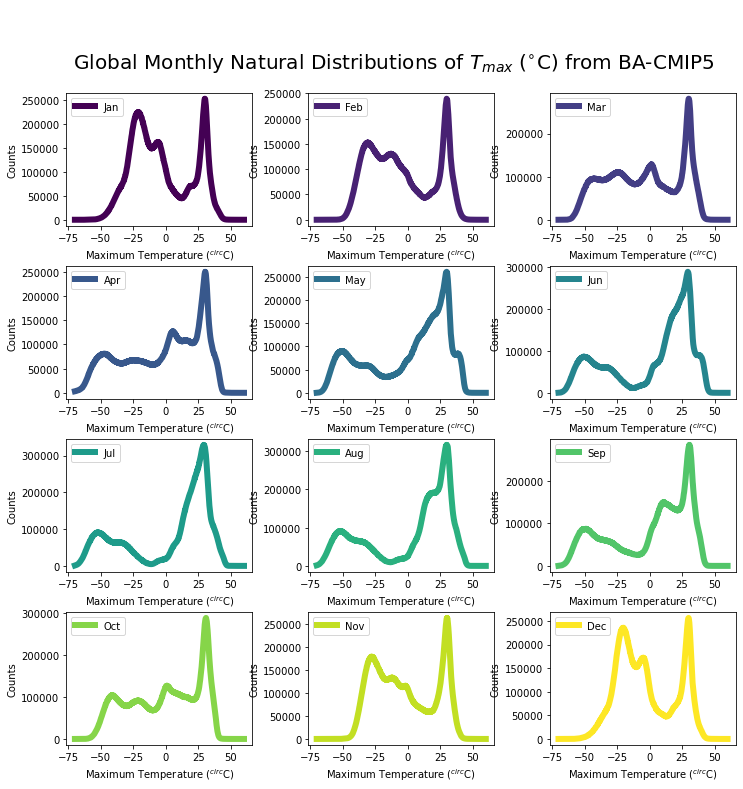

In [88]:
# set up figure
fig=plt.figure(figsize=(12,12))
# get things for the monthly pdfs
cols_mon=cmap(np.linspace(0,1,12))
monnames=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# loop over the months
for mi in np.arange(1,13):
    
    # get the keys for this month's data
    mon_varname='NaturalHist_'+str(mi).zfill(2)
    
    ## PLOT
    # get the subplot
    plt.subplot(4,3,mi)
    
    # plot the KDE
    plt.plot(pooledNat.bins,pooledNat[mon_varname].sum({'lat','lon'}).squeeze(),lw=6,color=cols_mon[mi-1],label=monnames[mi-1])
    
    # set other aspects of the plot
    plt.xlabel('Maximum Temperature ($^{circ}$C)')
    plt.ylabel('Counts')
    plt.legend(loc='upper left')

fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('\n\n Global Monthly Natural Distributions of $T_{max}$ ($^{\circ}$C) from BA-CMIP5',fontsize=20)
plt.show()

#### Seasonal

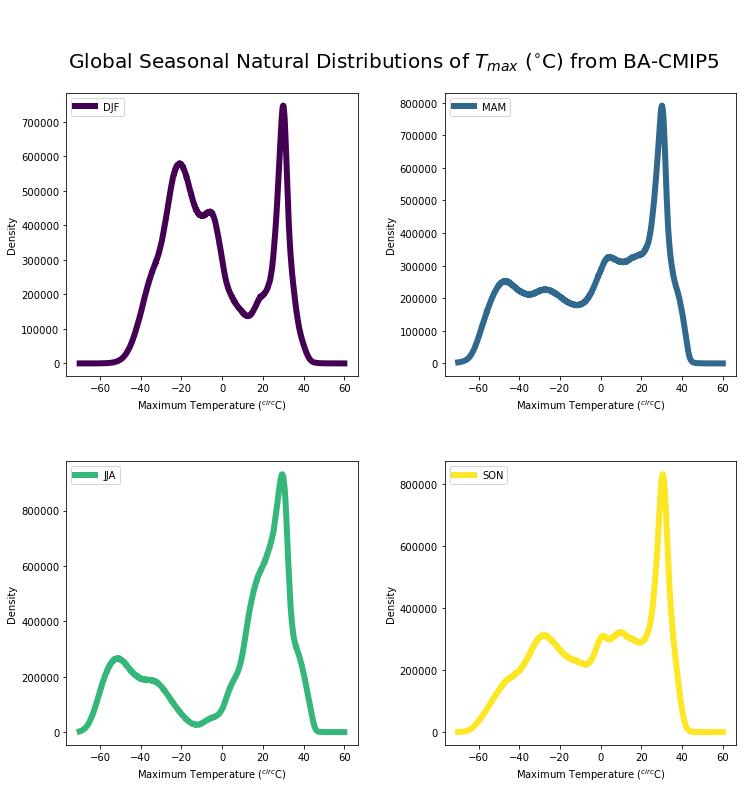

In [89]:
# set up figure
fig=plt.figure(figsize=(12,12))
# get things for the monthly pdfs
cols_seas=cmap(np.linspace(0,1,4))
seasnames=['DJF','MAM','JJA','SON']

# loop over each of the four seasons
for si in np.arange(4):
    
    # define the months we need depending on the season we are looking at
    if si==0:
        monneed=[12,1,2]
    elif si==1:
        monneed=[3,4,5]
    elif si==2:
        monneed=[6,7,8]
    elif si==3:
        monneed=[9,10,11]
    
    # get the keys for this month's data
    seasstr=['NaturalHist_'+str(i).zfill(2) for i in monneed]
    seaskeys=[i for i in pooledNat.keys() if any(x in i for x in seasstr)]
    
    # pool all of the month's Nat distributions by summing their counts
    pooled_seasonal_Natdist = pooledNat[seaskeys].to_array().sum("variable")
    # add to a list to be used later
    pooledNat.attrs['season']=seasnames[si]
    # add to the existing dataset
    seas_varname='NaturalHist_'+seasnames[si]
    pooledNat[seas_varname]=pooled_seasonal_Natdist
    
    ## PLOT
    # get the subplot
    plt.subplot(2,2,si+1)
    
    # plot the KDE
    plt.plot(pooledNat[seas_varname].bins, pooledNat[seas_varname].sum({'lat','lon'}).squeeze(),lw=6,color=cols_seas[si],label=seasnames[si])
    
    # set other aspects of the plot
    plt.xlabel('Maximum Temperature ($^{circ}$C)')
    plt.ylabel('Density')
    plt.legend(loc='upper left')

fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('\n\n Global Seasonal Natural Distributions of $T_{max}$ ($^{\circ}$C) from BA-CMIP5',fontsize=20)
plt.show()

# Resample and Look at Quantiles of Natural Distributions

1000.0
10000.0
100000.0
1000000.0
10000000.0


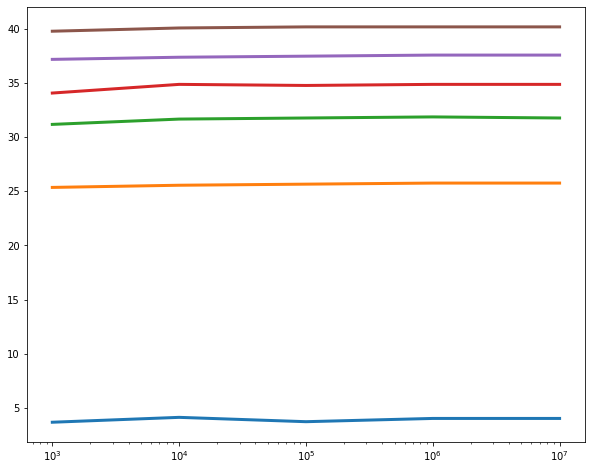

In [93]:
# check the quantiles and see how sensitive they are to the resample
ncheck=[1e3,1e4,1e5,1e6,1e7]
qcheck=[0.5,0.75,0.9,0.95,0.975,0.99]

# initialize
qvals=np.zeros((len(ncheck),len(qcheck)),dtype='float64')

# loop over the number of values to check
annual_array_to_resample=pooledNat['NaturalHist_Annual'].sum({'lat','lon'}).squeeze()
for i,n in enumerate(ncheck):
    
    print(n)
    # resample the pooled distribution with the new N
    poolcheck=util.randomly_sample_histogram(annual_array_to_resample,N=int(n))

    # calculate the quantiles
    qvals[i,:]=poolcheck.quantile(qcheck)
   
# plot and ensure the values converge to a single number
plt.figure(figsize=(10,8))
plt.semilogx(ncheck,qvals,lw=3)
plt.show()

In [94]:
print(np.diff(qvals,axis=0))

[[ 0.45    0.2     0.49    0.8     0.1975  0.299 ]
 [-0.4     0.1     0.1    -0.1     0.0975  0.1   ]
 [ 0.3     0.1     0.1     0.1     0.1     0.    ]
 [ 0.      0.     -0.1     0.      0.      0.    ]]


The quantile values converge (with delta < 0.01) after ~1e7 (ten million) samples, so we can use that going forward if we want to.

# Gather and Save out the final pooled distributions

In [100]:
pooled_Natdist=pooledNat.copy(deep=True)
attrs={'models':modelnames,
                    'time_period':'01/01/1975-12/31/2005',
                    'description':'Global Pooled distributions from CMIP5 Natural runs after Bias-adjustment',
                    'months':monnames,
                    'seasons':seasnames,
                    'precision':0.01
                }
pooled_Natdist.attrs=attrs

In [101]:
# create a save name
poolsavename='/home/dgilford/fingerprints/data/analysis/paper/natural_distributions/cmip5_pooled/CMIP5_pooledCF_global.nc'
pooled_Natdist.to_netcdf(poolsavename)

In [103]:
pooled_Natdist

<xarray.Dataset>
Dimensions:             (bins: 1301, lat: 145, lon: 192)
Coordinates:
  * bins                (bins) float64 -70.0 -69.9 -69.8 ... 59.8 59.9 60.0
  * lat                 (lat) float64 -90.0 -88.75 -87.5 ... 87.5 88.75 90.0
  * lon                 (lon) float64 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
Data variables: (12/17)
    NaturalHist_01      (lon, lat, bins) int32 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    NaturalHist_02      (lon, lat, bins) int32 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    NaturalHist_03      (lon, lat, bins) int32 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    NaturalHist_04      (lon, lat, bins) int32 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    NaturalHist_05      (lon, lat, bins) int32 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    NaturalHist_06      (lon, lat, bins) int32 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    ...                  ...
    NaturalHist_12      (lon, lat, bins) int32 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    NaturalHist_Annual  (lon, lat, bins) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    NaturalHist_DJF     (lon, lat, bins) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    NaturalHist_MAM     (lon, lat, bins) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    NaturalHist_JJA     (lon, lat, bins) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    NaturalHist_SON     (lon, lat, bins) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
Attributes:
    models:       ['CESM1-CAM5', 'CCSM4', 'NorESM1-M', 'GFDL-CM3', 'MIROC-ESM...
    time_period:  01/01/1975-12/31/2005
    description:  Global Pooled distributions from CMIP5 Natural runs after B...
    months:       ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'S...
    seasons:      ['DJF', 'MAM', 'JJA', 'SON']
    precision:    0.01